In [1]:
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
import pathlib
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

import h5py
import zipfile

from IPython.display import clear_output, display # clear the output if needed

import tensorflow as tf
from tensorflow import keras
import tensorboard
from tensorflow.keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback

import data_prep
import threshold
from tcn import TCN

%matplotlib inline
# %load_ext autoreload
# %autoreload 2

Prepare the notebook by downloading the milling data file and other important files. This needs to be done if running in google colab. If the repository has been cloned from github, then there is no need.

In [2]:
cwd = Path.cwd() # current working directory

folder_raw_data = Path('data/raw/') # raw data folder that holds the .zip .mat files for milling data
folder_processed_data = Path('data/processed/') # processed data folder
folder_models = Path('models/') # folder for saved models

In [3]:
# if the the raw data folder does not exist, then you are likely
# in a google colab environment. In that case, we will create the 
# raw data and processed data folders and download the appropriate
# files
if folder_raw_data.exists() == False:

    pathlib.Path(folder_raw_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_raw_data)
    !wget 'https://ti.arc.nasa.gov/m/project/prognostic-repository/mill.zip'
    
os.chdir(cwd) # change back to root directory

if folder_processed_data.exists() == False:

    pathlib.Path(folder_processed_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_processed_data)
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data/processed/labels_with_tool_class.csv'
    
    os.chdir(cwd)
    
    # download important python files into the main directory
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data_prep.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/tcn.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/threshold.py'
        

# extract mill.mat from the zip file
with zipfile.ZipFile(folder_raw_data / 'mill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)


Helper functions.

In [4]:
# simple functions used in the data prep

def scaler(x, min_val_array, max_val_array):
    '''
    Function to scale the data with min-max values
    '''

    # get the shape of the array
    s, _, sub_s = np.shape(x)

    for i in range(s):
        for j in range(sub_s):
            x[i, :, j] = np.divide(
                (x[i, :, j] - min_val_array[j]),
                np.abs(max_val_array[j] - min_val_array[j]),
            )

    return x


# min-max function
def get_min_max(x):
    '''
    Function to get the min-max values
    '''

    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x)

    min_vals = np.min(flat_vector, axis=0)
    max_vals = np.max(flat_vector, axis=0)

    return min_vals, max_vals


def load_train_test(directory):
    '''
    Function to quickly load the train/val/test data splits
    '''

    path = directory

    with h5py.File(path / "X_train.hdf5", "r") as f:
        X_train = f["X_train"][:]
    with h5py.File(path / "y_train.hdf5", "r") as f:
        y_train = f["y_train"][:]

    with h5py.File(path / "X_train_slim.hdf5", "r") as f:
        X_train_slim = f["X_train_slim"][:]
    with h5py.File(path / "y_train_slim.hdf5", "r") as f:
        y_train_slim = f["y_train_slim"][:]

    with h5py.File(path / "X_val.hdf5", "r") as f:
        X_val = f["X_val"][:]
    with h5py.File(path / "y_val.hdf5", "r") as f:
        y_val = f["y_val"][:]

    with h5py.File(path / "X_val_slim.hdf5", "r") as f:
        X_val_slim = f["X_val_slim"][:]
    with h5py.File(path / "y_val_slim.hdf5", "r") as f:
        y_val_slim = f["y_val_slim"][:]

    with h5py.File(path / "X_test.hdf5", "r") as f:
        X_test = f["X_test"][:]
    with h5py.File(path / "y_test.hdf5", "r") as f:
        y_test = f["y_test"][:]

    return (
        X_train,
        y_train,
        X_train_slim,
        y_train_slim,
        X_val,
        y_val,
        X_val_slim,
        y_val_slim,
        X_test,
        y_test,
    )

# functions needed for model training
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Data Exploration

Explore the matlab file first.

In [5]:
# load the data from the matlab file
m = sio.loadmat(folder_raw_data / 'mill.mat',struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

Get an idea of the stucture of the data array.

In [6]:
# show some of the info from the matlab file
print('Keys in the matlab dict file: \n', m.keys(), '\n')

# store the field names in the data np array in a tuple, l
l = data.dtype.names
print('List of the field names:\n',l)

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


Store the label information in its own dataframe.

In [7]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


Make a simple plot to look at some of the data.

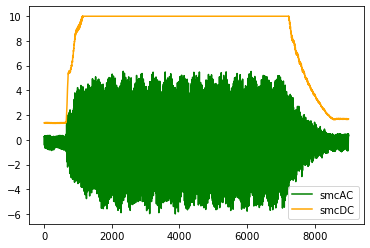

In [8]:
fig, ax = plt.subplots()

ax.plot(data[0,166]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,166]['smcDC'],color='orange',label='smcDC')

plt.legend()

If you look at all the cuts, you'll find that cuts 18 and 95 (index 17 and 94) are off -- they should be discarded.

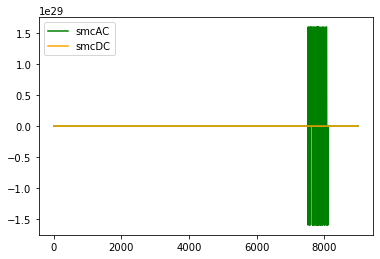

In [9]:
fig, ax = plt.subplots()

ax.plot(data[0,17]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,17]['smcDC'],color='orange',label='smcDC')

plt.legend()

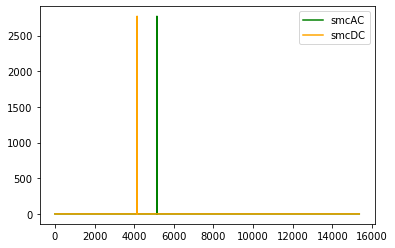

In [10]:
fig, ax = plt.subplots()

ax.plot(data[0,94]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,94]['smcDC'],color='orange',label='smcDC')

plt.legend()

Cut 106 is also weird...

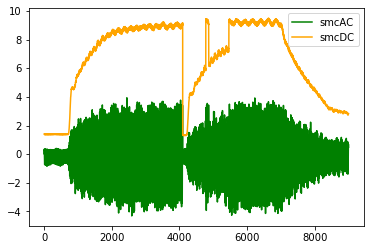

In [11]:
fig, ax = plt.subplots()

ax.plot(data[0,105]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,105]['smcDC'],color='orange',label='smcDC')

plt.legend()

We'lll create a pretty plot of all the six signals for a certain cut.

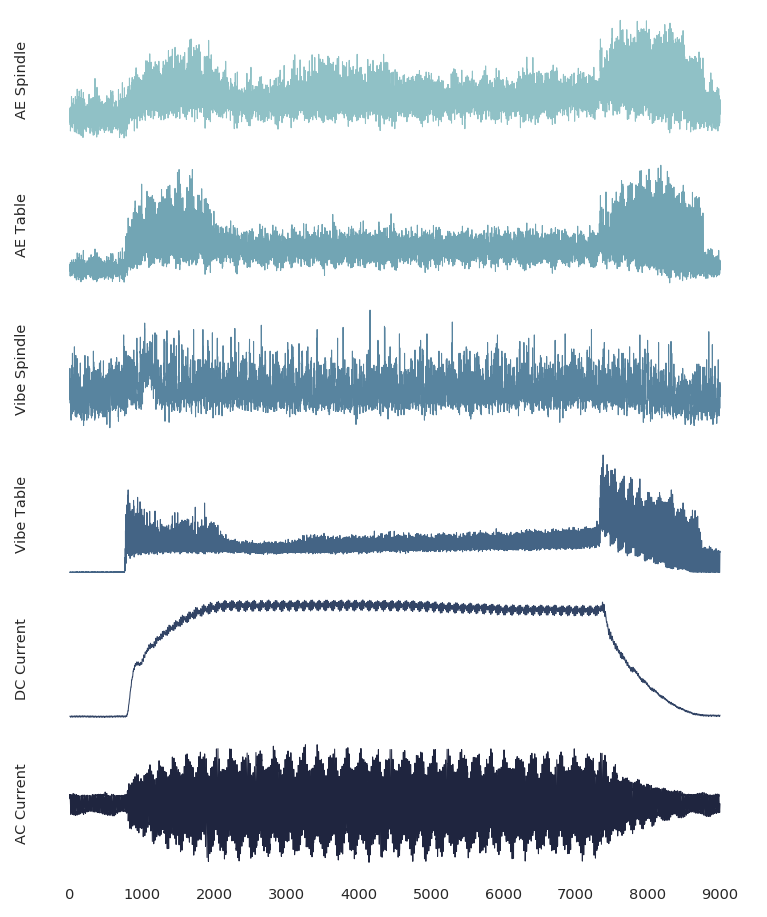

In [12]:
def plot_cut(cut_signal, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signals
        axes[i].plot(cut_signal[signals_trend[i]], color=pal[i], linewidth=0.5, alpha=1)
        axis_label = signal_names_revised[i]
        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal...
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_xticks(
                [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
            )
            axes[i].set_yticks([])

        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)


signals_trend = list(l[7:])  # there are 6 types of signals, smcAC to AE_spindle
signals_trend = signals_trend[
    ::-1
]  # reverse the signal order so that it is matching other charts
cut_signal = data[0, 145]

plot_cut(cut_signal, signals_trend, "cut_145")
plt.show()

# Data Prep

We'll create the X and y data sets and split them into their respective training/validation/testing sets. We'll save the data in hdf5 files.

In [5]:
data_file = folder_raw_data / "mill.mat"

prep = data_prep.DataPrep(data_file)

# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv(
    folder_processed_data / 'labels_with_tool_class.csv'
)


# discard certain cuts as they are strange
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace=True)


X, y, dfy = prep.return_xy(df_labels, prep.data,prep.field_names[7:],window_size=64, stride=64, track_y=True)

X_train, X_test, dfy_train, dfy_test = train_test_split(X, dfy, test_size=0.33, random_state=15, 
                                                    stratify=dfy['class'])
X_val, X_test, dfy_val, dfy_test = train_test_split(X_test, dfy_test, test_size=0.50, random_state=10, 
                                                stratify=dfy_test['class'])

y_train = dfy_train['class'].to_numpy(dtype='int')
y_val = dfy_val['class'].to_numpy(dtype='int')
y_test = dfy_test['class'].to_numpy(dtype='int')




min_vals, max_vals = get_min_max(X_train)

# scale the data sets
X = scaler(X, min_vals, max_vals)
X_train = scaler(X_train, min_vals, max_vals)
X_val = scaler(X_val, min_vals, max_vals)
X_test = scaler(X_test, min_vals, max_vals)

print('Min/max values from X_train:')
print(min_vals)

print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("\nShape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# slim down the X_train and X_val
X_train_slim, y_train_slim = prep.remove_classes([1, 2], y_train, X_train)

print("\nShape of X_train_slim:", X_train_slim.shape)
print("Shape of y_train_slim:", y_train_slim.shape)

X_val_slim, y_val_slim = prep.remove_classes([1, 2], y_val, X_val)

print("\nShape of X_val_slim:", X_val_slim.shape)
print("Shape of y_val_slim:", y_val_slim.shape)

signal_names = prep.field_names[7:] # get signal names
signal_names = signal_names[::-1] # reverse order so that it is same as in data structure

Min/max values from X_train:
[-6.96777344  3.41796875  0.20263672  0.21850586  0.01464844  0.09094238]

Shape of X_train: (7751, 64, 6)
Shape of y_train: (7751,)

Shape of X_val: (1909, 64, 6)
Shape of y_val: (1909,)

Shape of X_test: (1910, 64, 6)
Shape of y_test: (1910,)

Shape of X_train_slim: (2831, 64, 6)
Shape of y_train_slim: (2831,)

Shape of X_val_slim: (697, 64, 6)
Shape of y_val_slim: (697,)


Save the data splits in the processed data folder (also save the "slimmed" down versions of the X_train and X_val).

In [6]:
# X_train, y_train
with h5py.File("data/processed/X_train.hdf5", "w") as f:
    dset = f.create_dataset("X_train", data=X_train)
with h5py.File("data/processed/y_train.hdf5", "w") as f:
    dset = f.create_dataset("y_train", data=y_train)

# X_val, y_val
with h5py.File("data/processed/X_val.hdf5", "w") as f:
    dset = f.create_dataset("X_val", data=X_val)
with h5py.File("data/processed/y_val.hdf5", "w") as f:
    dset = f.create_dataset("y_val", data=y_val)

# X_test, y_test
with h5py.File("data/processed/X_test.hdf5", "w") as f:
    dset = f.create_dataset("X_test", data=X_test)
with h5py.File("data/processed/y_test.hdf5", "w") as f:
    dset = f.create_dataset("y_test", data=y_test)


with h5py.File("data/processed/X_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_train_slim", data=X_train_slim)
with h5py.File("data/processed/y_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_train_slim", data=y_train_slim)

with h5py.File("data/processed/X_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_val_slim", data=X_val_slim)
with h5py.File("data/processed/y_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_val_slim", data=y_val_slim)

# Train Models

In [15]:
print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

TensorFlow version:  2.1.0
Keras version:  2.2.4-tf
Tensorboard version: 2.1.0


## Fit Model Function
Function used to train the beta-VAE.

In [17]:
# build custom sampling function
# some code modified from Aurelion Geron, 
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# code used under Apache 2.0 License, https://github.com/ageron/handson-ml2/blob/master/LICENSE

K = keras.backend

# class for sampling embeddings in the latent space
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


# fit the model
def model_fit(
    X_train_slim,
    X_val_slim,
    beta_value=1.25,
    codings_size=10,
    dilations=[1, 2, 4],
    conv_layers=1,
    seed=31,
    start_filter_no=32,
    kernel_size_1=2,
    epochs=10,
    earlystop_patience=8,
    verbose=0,
    compile_model_only=False,
):

    # try the first if it is the milling data
    # else it will be the CNC data
    try:
        _, window_size, feat = X_train_slim.shape

    except:
        window_size = X_train_slim.shape
        feat = 1

    date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tf.random.set_seed(seed)
    np.random.seed(seed)

    end_filter_no = start_filter_no

    inputs = keras.layers.Input(shape=[window_size, feat])
    z = inputs

    # ENCODER
    ####### TCN #######
    for i in range(0, conv_layers):
        z = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(z)

        z = keras.layers.BatchNormalization()(z)
        z = keras.layers.MaxPool1D(pool_size=2)(z)

    z = keras.layers.Flatten()(z)
    print("Shape of Z:", z.shape)

    codings_mean = keras.layers.Dense(codings_size)(z)

    codings_log_var = keras.layers.Dense(codings_size)(z)

    codings = Sampling()([codings_mean, codings_log_var])

    variational_encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
    )

    # DECODER
    decoder_inputs = keras.layers.Input(shape=[codings_size])

    x = keras.layers.Dense(
        start_filter_no * int((window_size / (2 ** conv_layers))), activation="selu"
    )(decoder_inputs)

    x = keras.layers.Reshape(
        target_shape=((int(window_size / (2 ** conv_layers))), end_filter_no)
    )(x)

    for i in range(0, conv_layers):
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.BatchNormalization()(x)

        x = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(x)

    outputs = keras.layers.Conv1D(
        feat, kernel_size=kernel_size_1, padding="same", activation="sigmoid"
    )(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae_beta = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

    latent_loss = (
        -0.5
        * beta_value
        * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1,
        )
    )

    variational_ae_beta.add_loss(K.mean(latent_loss) / (window_size * feat))
    variational_ae_beta.compile(
        loss="binary_crossentropy",
        optimizer="adam",  #'rmsprop'
        metrics=[rounded_accuracy],
    )

    # count the number of parameters
    param_size = "{:0.2e}".format(
        variational_encoder.count_params() + variational_decoder.count_params()
    )

    # Uncomment these if you want to see the summary of the encoder/decoder
    # variational_encoder.summary()
    # variational_decoder.summary()

    # Model Name
    # b : beta value used in model
    # c : number of codings -- latent variables
    # l : numer of convolutional layers in encoder (also decoder)
    # f1 : the starting number of filters in the first convolution
    # k1 : kernel size for the first convolution
    # k2 : kernel size for the second convolution
    # d : whether dropout is used when sampling the latent space (either True or False)
    # p : number of parameters in the model (encoder + decoder params)
    # eps : number of epochs
    # pat : patience stopping number

    model_name = (
        "TBVAE-{}:_b={:.2f}_c={}_l={}_f1={}_k1={}_dil={}"
        "_p={}_eps={}_pat={}".format(
            date_time,
            beta_value,
            codings_size,
            conv_layers,
            start_filter_no,
            kernel_size_1,
            dilations,
            param_size,
            epochs,
            earlystop_patience,
        )
    )

    print("\n", model_name, "\n")

    if compile_model_only == False:
        # save the model summary into a text file (from stack overflow http://bit.ly/2DHI6fM)
        with open("models/saved_models/" + date_time + "_report.txt", "w") as fh:
            variational_encoder.summary(print_fn=lambda x: fh.write(x + "\n"))
            variational_decoder.summary(print_fn=lambda x: fh.write(x + "\n"))

        # # use tensorboard to track training
        # log_dir = "logs/" + date_time + "_" + model_name
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir, histogram_freq=0, update_freq="epoch", profile_batch=0
        # )

        earlystop_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0.0002,
            patience=earlystop_patience,
            restore_best_weights=True,
            verbose=1,
        )

        history = variational_ae_beta.fit(
            X_train_slim,
            X_train_slim,
            epochs=epochs,
            batch_size=1024,
            shuffle=True,
            validation_data=[X_val_slim, X_val_slim],
            callbacks=[earlystop_callback,],  # tensorboard_callback,
            verbose=verbose,
        )

        return date_time, model_name, history, variational_ae_beta, variational_encoder

    else:

        return variational_ae_beta, variational_encoder

## Random Search
Perform the random search to train the models. We will also save the trained models (both the encoder and decoder).

In [4]:
# load the data splits
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) 

NameError: name 'load_train_test' is not defined

Setup the parameters for the random search and training.

In [18]:
# Input the number of iterations you want to search over
random_search_iterations = 2

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
p_bvae_grid = {
    "beta_value": uniform(loc=0.5, scale=9),
    "codings_size": sp_randint(5, 40),
    "conv_layers": [3, 2, 1],
    "start_filter_no": sp_randint(16, 128),
    "dilations": [[1, 2, 4, 8], [1, 2, 4], [1, 2]],
    "kernel_size_1": sp_randint(2, 9),
    "earlystop_patience": sp_randint(30, 50),
}

# epochs
epochs = 2

In [19]:
# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

In [20]:
# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(p_bvae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
        # parameters  
    beta_value =params["beta_value"]
    codings_size =params["codings_size"]
    conv_layers =params["conv_layers"]   
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    dilations = params["dilations"]
    earlystop_patience=params["earlystop_patience"]
    

    seed = 16
    verbose = 1

    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        date_time, model_name, history, beta_vae_model, bvae_encoder = model_fit(
            X_train_slim,
            X_val_slim,
            beta_value=beta_value,
            codings_size=codings_size,
            conv_layers=conv_layers,
            seed=seed,
            start_filter_no=start_filter_no,
            kernel_size_1=kernel_size_1,
            dilations=dilations,
            epochs=epochs,
            earlystop_patience=earlystop_patience,
            verbose=verbose,
        )

        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_bvae = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_bvae")
        )
        model_save_dir_encoder = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_encoder")
        )

        # create the save paths
        Path(model_save_dir_bvae).mkdir(parents=True, exist_ok=True)
        Path(model_save_dir_encoder).mkdir(parents=True, exist_ok=True)

        # save entire bvae model
        model_as_json = beta_vae_model.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_bvae)), "w",) as json_file:
            json_file.write(model_as_json)
        beta_vae_model.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # save encoder bvae model
        model_as_json = bvae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        bvae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        # results = list(results[results['loss']==results['loss'].min()].to_numpy()) # only keep the top result, that is, the lowest val_loss
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("results_interim_{}.csv".format(model_save_folder))

    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass


### Run no. 1
Shape of Z: (None, 224)

 TBVAE-20200824-144509:_b=6.45_c=32_l=3_f1=28_k1=8_dil=[1, 2, 4]_p=2.65e+05_eps=2_pat=40 

Train on 2831 samples, validate on 697 samples
Epoch 1/2
2831/2831 [==============================] - 15s 5ms/sample - loss: 1.8101 - rounded_accuracy: 0.7496 - val_loss: 525.8168 - val_rounded_accuracy: 0.4985
Epoch 2/2
2831/2831 [==============================] - 1s 313us/sample - loss: 0.8715 - rounded_accuracy: 0.7258 - val_loss: 18.7021 - val_rounded_accuracy: 0.6452

### Run no. 2
Shape of Z: (None, 192)

 TBVAE-20200824-144528:_b=5.19_c=30_l=3_f1=24_k1=5_dil=[1, 2]_p=9.53e+04_eps=2_pat=38 

Train on 2831 samples, validate on 697 samples
Epoch 1/2
2831/2831 [==============================] - 10s 4ms/sample - loss: 2.3687 - rounded_accuracy: 0.5168 - val_loss: 2906184960.0000 - val_rounded_accuracy: 0.5736
Epoch 2/2
2831/2831 [==============================] - 0s 154us/sample - loss: 1.2896 - rounded_accuracy: 0.5887 - val_loss: 174954416.0000 - val_ro

# Analysis
Now we'll look at the best model trained.

First, we're interested in see how imbalanced the data set is. This will help inform the results

In [7]:
# reload the data sets, just in case they were corrupted
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) 

In [8]:
# function to show the percentage of labels in y-labels
def y_shape_percentage(y_train, label):
    
    l = y_train
    
    print('shape {}:'.format(label), l.shape, 
          '\t\t0: {:.1%}'.format(len(l[l == 0])/len(l)), 
          '\t\t1: {:.1%}'.format(len(l[l == 1])/len(l)), 
          '\t\t2: {:.1%}'.format(len(l[l == 2])/len(l)))
    
# let's see what percentage of the data set splits are made up of healthy (0), degraded (1),
# and failed (2) labels
y_shape_percentage(y_train, 'y_train')
y_shape_percentage(y_val, 'y_val')
y_shape_percentage(y_test, 'y_test')

shape y_train: (7751,) 		0: 36.5% 		1: 56.2% 		2: 7.3%
shape y_val: (1909,) 		0: 36.5% 		1: 56.2% 		2: 7.3%
shape y_test: (1910,) 		0: 36.5% 		1: 56.2% 		2: 7.3%


Function needed to help in the analysis:

In [11]:
def mse(X_val,recon_val):
    """Calculate MSE for images in X_val and recon_val"""
    
    # need to calculate mean across the rows, and then across the columns
    return np.mean(np.square(X_val.astype('float32') - recon_val.astype('float32')),axis=1)

def mse_total(X_val,recon_val):
    """Calculate MSE for images in X_val and recon_val"""
    
    # need to calculate mean across the rows, and then across the columns
    return np.mean(np.mean(np.square(X_val.astype('float32') - recon_val.astype('float32')),axis=1),axis=1)

def moving_average(a, n=3) :
    # from https://stackoverflow.com/a/14314054
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def kl_divergence(mu, log_var):
    return (
        -0.5
        * K.sum(
            1 + log_var - K.exp(log_var) - K.square(mu),
            axis=-1,
        )
    )

def sorted_x(X, dfy, case):
    index_keep = dfy[dfy['case']==case].sort_values(by=['counter'].copy()).index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy['case']==case].sort_values(by=['counter'])['class'].copy())
    return X_sorted, y_sorted


def filter_x_material(X, dfy, material='cast_iron'):
    
    cast_iron_cases = [1, 2,3,4,9,10,11,12]
    steel_cases = list(list(set(range(1,17))-set(cast_iron_cases)))
    
    if material == 'cast_iron':
        case_list = cast_iron_cases
    else:
        # material is 'steel'
        case_list = steel_cases
    
    index_keep = dfy[dfy['case'].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy['case'].isin(case_list)]['class'].copy(), dtype='int')
    return X_sorted, y_sorted

def filter_x_feed(X, dfy, feed):
    fast_feed_cases = [1,2,5,8,9,12,14,16]
    slow_feed_cases = list(list(set(range(1,17))-set(fast_feed_cases)))
    
    if feed == 0.5:
        case_list = fast_feed_cases
    else:
        # feed is 0.25
        case_list = slow_feed_cases
    
    index_keep = dfy[dfy['case'].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy['case'].isin(case_list)]['class'].copy(), dtype='int')
    return X_sorted, y_sorted

def filter_x_depth(X, dfy, feed):
    deep_cases = [1,4,5,6,9,10,15,16]
    shallow_cases = list(list(set(range(1,17))-set(deep_cases)))
    
    if feed == 1.5:
        case_list = deep_cases
    else:
        # depth is 0.75
        case_list = shallow_cases
    
    index_keep = dfy[dfy['case'].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy['case'].isin(case_list)]['class'].copy(), dtype='int')
    return X_sorted, y_sorted


def build_mre_scores(model, X,):
    '''Build the mean-reconstruction-error values from the '''
    
    # build the MRE values for each individual signal (mres_all) and for the average across
    # all six signals (mre_avg)
    mres_all = [] # instantiate the lists to store the values
    dummies_all = []
    mres_avg = []
    dummies_avg = []
    
    # X's should already be scaled
    # X = scaler(X, min_vals, max_vals)
    recon = model.predict(X, batch_size=64)
    # all the signals
    mre_all = mse(X, recon)

    # average of the signals
    mre_avg = mse_total(X, recon)
   
    return mre_all, mre_avg

def build_kls_scores(encoder, X,):
    codings_mean,codings_log_var,codings = encoder.predict(X,batch_size=64)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    return kls

def pr_auc_kl(encoder, X, y,grid_iterations=10, 
              date_model_ran='date', 
              model_name='encoder',
              class_to_remove=[2]):
    
    codings_mean, codings_log_var, codings = encoder.predict(X,batch_size=64)
    
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    kls = np.reshape(kls, (-1,1))

    lower_bound = np.min(kls)
    upper_bound = np.max(kls)
    
    recon_check = threshold.SelectThreshold(encoder,X, y, X, 
                                            X, y, 
                                            X, 
                                            class_to_remove, 
                                            class_names=['0','1','2'], model_name=model_name, 
                                            date_time=date_model_ran,)

    best_threshold, best_roc_score, precisions, recalls, tprs, fprs =recon_check.threshold_grid_search(
            y,
            lower_bound,
            upper_bound,
            kls,
            grid_iterations,)

    pr_auc_score_train = auc(recalls, precisions)
    roc_auc_score_train = auc(fprs, tprs)
    return pr_auc_score_train, roc_auc_score_train, recalls, precisions, tprs, fprs, best_threshold

In [12]:
def get_latent_input_anomaly_scores(model_name, saved_model_dir, class_to_remove, 
                                    X_train, y_train, X_val, y_val,
                                    grid_iterations, search_iterations, 
                                    X_train_slim=X_train_slim, X_val_slim=X_val_slim):
    
    date_model_ran = model_name.split('_')[0]

    # input space anomaly detection
    loaded_json = open(r'{}/{}/model.json'.format(saved_model_dir,model_name), 'r').read()
    beta_vae_model = model_from_json(loaded_json, custom_objects={'TCN': TCN, 'Sampling': Sampling})

    # restore weights
    beta_vae_model.load_weights(r'{}/{}/weights.h5'.format(saved_model_dir,model_name))


    recon_check = threshold.SelectThreshold(beta_vae_model,X_train, y_train, X_train_slim, 
                                            X_val, y_val, 
                                            X_val_slim, 
                                            class_to_remove, 
                                            class_names=['0','1','2'], model_name=model_name, 
                                            date_time=date_model_ran,)

    df = recon_check.compare_error_method(show_results=False, 
                                          grid_iterations=grid_iterations,
                                          search_iterations=search_iterations)

    # latent space anomaly detection

    loaded_json = open(r'{}/{}/model.json'.format(saved_model_dir,date_model_ran+'_encoder'), 'r').read()
    encoder = model_from_json(loaded_json, custom_objects={'TCN': TCN, 'Sampling': Sampling})

    # restore weights
    encoder.load_weights(r'{}/{}/weights.h5'.format(saved_model_dir,date_model_ran+'_encoder'))


    prauc_train_kls = []
    prauc_val_kls = []
    roc_train_kls = []
    roc_val_kls = []
    recalls_array = []
    precisions_array = []
    tprs_array = []
    fprs_array = []

    for i in range(search_iterations):
        print('search_iter:',i)
        # train
        (pr_auc_score_train, 
         roc_auc_score_train, 
         recalls, precisions, 
         tprs, fprs, 
         best_threshold_kl) =pr_auc_kl(encoder, X_train, y_train ,
                                                           grid_iterations=grid_iterations, 
                                                              date_model_ran='date', 
                                                              model_name='encoder',
                                                              class_to_remove=class_to_remove)

        prauc_train_kls.append(pr_auc_score_train)
        roc_train_kls.append(roc_auc_score_train)

        # val
        (pr_auc_score_val, 
         roc_auc_score_val, 
         recalls, precisions, 
         tprs, fprs, 
         best_threshold) =pr_auc_kl(encoder, X_val, y_val, 
                                                           grid_iterations=grid_iterations, 
                                                          date_model_ran='date', 
                                                          model_name='encoder',
                                                          class_to_remove=class_to_remove)
        

        prauc_val_kls.append(pr_auc_score_val)
        roc_val_kls.append(roc_auc_score_val)
        recalls_array.append(recalls)
        precisions_array.append(precisions)
        tprs_array.append(tprs)
        fprs_array.append(fprs)

    df['pr_auc_train_score_kl'] = np.mean(np.array(prauc_train_kls))
    df['pr_auc_val_score_kl'] = np.mean(np.array(prauc_val_kls))
    df['roc_train_score_kl'] = np.mean(np.array(roc_train_kls))
    df['roc_val_score_kl'] = np.mean(np.array(roc_val_kls))
    df['best_threshold_kl'] = best_threshold_kl
    
    recalls_array = np.array(recalls_array)
    precisions_array = np.array(precisions_array)
    tprs_array = np.array(tprs_array)
    fprs_array = np.array(fprs_array)

    return df, recalls_array, precisions_array, tprs_array, fprs_array

In [14]:
X_train_slim.shape

(2831, 64, 6)

In [15]:
# # data set used to train the model
# dir_processed_data = Path('/home/tim/Documents/milling/data/processed')

# data_folder = dir_processed_data / '2016_06_18_milling_mash_stride64'

# # load the slim data from teh data_folder
# (_, _, 
# X_train_slim, y_train_slim,
# _, _,
# X_val_slim, y_val_slim,
# _,_) = load_train_test(data_folder)

# print('X_train_slim shape:',X_train_slim.shape)
# print('X_val_slim shape:',X_val_slim.shape)

In [16]:
model_folder = './models/best_models'
model_name = '20200620-053315_bvae'

grid_iterations = 250
search_iterations = 1

# get results for train and validation sets
dfr_val, _, _, _, _ = get_latent_input_anomaly_scores(model_name, model_folder, [2], 
                                    X_train, y_train, X_val, y_val,
                                    grid_iterations=grid_iterations, search_iterations=search_iterations, 
                                    X_train_slim=X_train_slim, X_val_slim=X_val_slim)

date_time =  dfr_val['date_time'][0]
best_threshold = dfr_val['best_threshold'][0]
best_threshold_kl = dfr_val['best_threshold_kl'][0]
pr_auc_train_score = dfr_val['pr_auc_train_score'][0]
pr_auc_val_score = dfr_val['pr_auc_val_score'][0]
pr_auc_train_score_kl = dfr_val['pr_auc_train_score_kl'][0]
pr_auc_val_score_kl = dfr_val['pr_auc_val_score_kl'][0]

# get results for test set
dfr_test, recalls, precisions, tprs, fprs = get_latent_input_anomaly_scores(model_name, model_folder, [2], 
                                    X_train, y_train, X_test, y_test,
                                    grid_iterations=grid_iterations, search_iterations=search_iterations, 
                                    X_train_slim=X_train_slim, X_val_slim=X_val_slim)

best_threshold_mre_test = dfr_test['best_threshold'][0]
best_threshold_kl_test = dfr_test['best_threshold_kl'][0]
pr_auc_test_score = dfr_test['pr_auc_val_score'][0]
pr_auc_test_score_kl = dfr_test['pr_auc_val_score_kl'][0]


# collate the results into one dataframe
df_result = pd.DataFrame()

df_result['Data Set'] = ['train','validation','test']
df_result['PR-AUC Input Space'] = [pr_auc_train_score, pr_auc_val_score, pr_auc_test_score]
df_result['PR-AUC Latent Space'] = [pr_auc_train_score_kl, pr_auc_val_score_kl, pr_auc_test_score_kl]
clear_output(wait=True)
df_result

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.376927,0.391694
1,validation,0.433502,0.493395
2,test,0.418776,0.449931


In [17]:
roc_auc_val = auc(fprs[0,:], tprs[0,:])
print(roc_auc_val)
pr_auc_val = auc(recalls[0,:], precisions[0,:])
print(pr_auc_val)

0.8827817474986697
0.4499313153576303


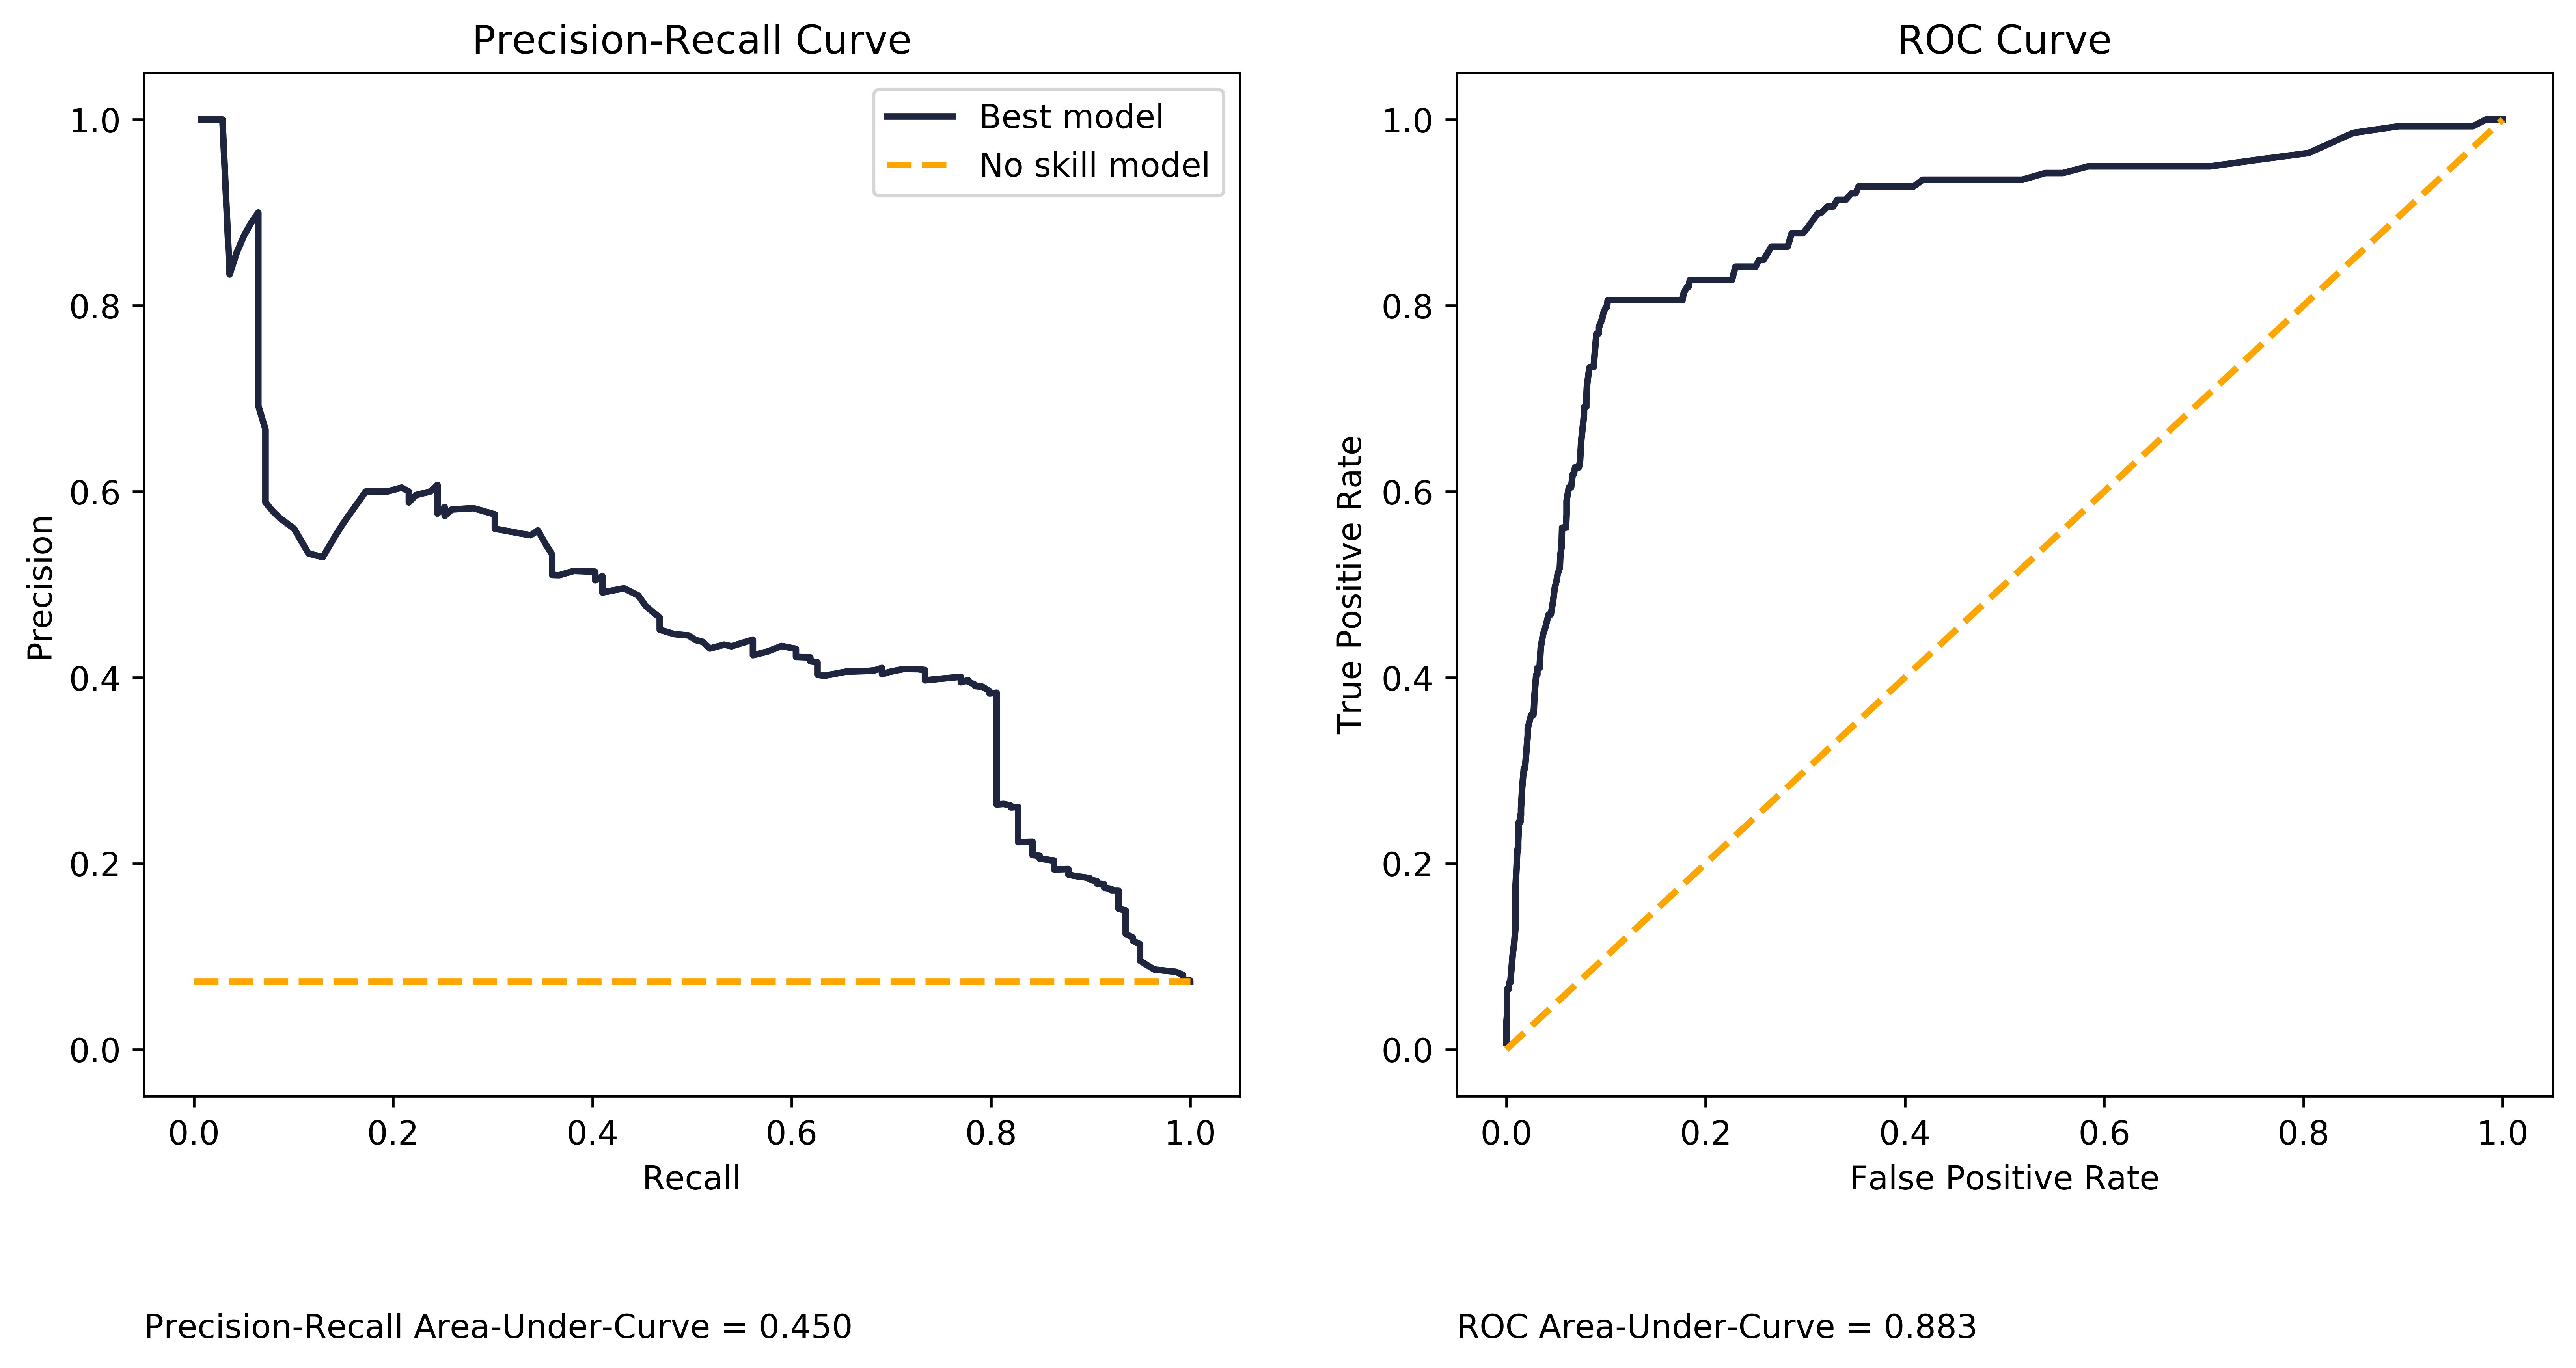

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True,dpi=600)
fig.tight_layout(pad=5.0)

pal = sns.cubehelix_palette(6, rot=-.25, light=.7)

# sns.lineplot(x=recalls[0,:], y=precisions[0,:], ax=ax[0], linewidth=2, alpha=1, color=pal[5], estimator=None)
axes[0].plot(recalls[0,:], precisions[0,:], marker='', label='Best model', color=pal[5], linewidth=2)
axes[0].plot(np.array([0,1]),np.array([0.073,0.073]), marker='',  linestyle='--', label='No skill model', 
             color='orange', linewidth=2)
axes[0].legend()
axes[0].title.set_text('Precision-Recall Curve')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].text(x=-0.05, y=-0.3, s='Precision-Recall Area-Under-Curve = {:.3f}'.format(pr_auc_val),
                     horizontalalignment='left',
                     verticalalignment='center', rotation='horizontal',alpha=1)


axes[1].plot(fprs[0,:], tprs[0,:], marker='', label='Best model', color=pal[5], linewidth=2,)
axes[1].plot(np.array([0,1]),np.array([0,1]), marker='',  linestyle='--', label='No skill', 
             color='orange', linewidth=2)
axes[1].title.set_text('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].text(x=-0.05, y=-0.3, s='ROC Area-Under-Curve = {:.3f}'.format(roc_auc_val),
                     horizontalalignment='left',
                     verticalalignment='center', rotation='horizontal',alpha=1)

for ax in axes.flatten():
#     ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True, which='major')
    ax.grid(False)
#     ax.tick_params(axis='both', which='major',length=1)

# plt.savefig('prauc_600dpi.pdf',dpi=600,bbox_inches = "tight")
plt.show()
